In [1]:
"""
[Best LB]
Blend 5 Models:
* kibuna-nn-hs-1024-last-train (aka. 2stage-NN, LB: 0.01822)
* deepinsight-efficientnet-v7-b3-infer (LB: 0.01850)
* deepinsight_resnest_lightning_v2_infer (LB: 0.01854)
* 503-203-tabnet-with-nonscored-features (LB: 0.01836)
* simpleNN-oldcv (LB: 0.01836)
* simpleNN-newcv (LB: 0.01836)
* fork-of-2heads-looper-super-puper-markpeng-infer (LB: 0.1836)

[Best CV]
Blend 5 Models:
* kibuna-nn-hs-1024-last-train (aka. 2stage-NN, LB: 0.01822)
* deepinsight-efficientnet-v7-b3-infer (LB: 0.01850)
* deepinsight_resnest_lightning_v2_infer (LB: 0.01854)
* deepinsight_resnest_lightning_v1_infer (LB: 0.01853)
* improving-mark-s-2-heads-model-infer.py (LB: 0.1844)

Removed for now due to low weights:
* 503-203-tabnet-with-nonscored-features (LB: 0.01836)
* simpleNN-oldcv (LB: 0.01836)
* fork-of-2heads-looper-super-puper-markpeng-infer (LB: 0.1836)

"""

kernel_mode = False

import os
import numpy as np
import pandas as pd
import time
import random
import math
import datetime
import glob

pd.set_option('display.max_rows', None)

from numba import njit
from scipy.optimize import minimize, fsolve

import optuna

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import gc
gc.enable()

rand_seed = 1120

search_mode = True
run_submit_script = False

method = "CV"
# method = "scipy"
# method = "optuna"
study_name = "moa_blend_team_v7"
# n_trials = 500
# n_trials = 3000
n_trials = 5000

# Best CV

In [41]:
dataset_folder = "../input/lish-moa" if kernel_mode else "/workspace/Kaggle/MoA/"

# Add your model inference script here
# Tuple Format: (script, oof_filename, output_filename, weight)
model_list = [
    # 10 folds
    ("2stageNN_with_ns_oldcv_10folds.py" if kernel_mode else
     "../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv_10folds.py",
     "../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv_10folds.npy",
     "submission_2stageNN_with_ns_oldcv_10folds.csv", 0.36295047115403034),

    #     ("script_simpleNN_oldcv_10folds.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/script_simpleNN_oldcv_10folds.py",
    #      "../../Github/kaggle_moa_team/oof/oof_NN_oldcv_10fold.npy",
    #      "submission_script_simpleNN_oldcv_10folds.csv",
    #      0.00019665601658366993),

    #     ("2stageNN_with_ns_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv.py",
    #      "../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv.npy",
    #      "submission_2stageNN_with_ns_oldcv_0.01822.csv",
    #      0.323528084383917),

    #     ("script_simpleNN_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/script_simpleNN_oldcv.py",
    #      "../../Github/kaggle_moa_team/oof/oof_script_simpleNN_oldcv.npy",
    #      "submission_script_simpleNN_oldcv_0.01836.csv",
    #      0.08786476491118465),

    #     ("fork-of-2heads-looper-super-puper-markpeng-infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/fork-of-2heads-looper-super-puper-markpeng-infer.py",
    #      "../../Github/kaggle_moa_team/oof/oof_fork-of-2heads-looper-super-puper-markpeng.npy",
    #      "submission_2heads-looper-super-puper_0.01836.csv",
    #      0.018966959973949222),
    ("improving-mark-s-2-heads-model-infer.py" if kernel_mode else
     "../../Github/kaggle_moa_team/scripts/improving-mark-s-2-heads-model-infer.py",
     "../../Github/kaggle_moa_team/oof/oof_improving-mark-s-2-heads-model_0.015660083675738144.npy",
     "submission_improving-mark-s-2-heads-model.csv", 0.10383226438101152),
    ("deepinsight_efficientnet_lightning_v7_b3_infer.py" if kernel_mode else
     "../../Github/kaggle_moa_team/scripts/deepinsight_efficientnet_lightning_v7_b3_infer.py",
     "../../Github/kaggle_moa_team/oof/oof_deepinsight_efficientnet_lightning_v7_b3_0.01850.npy",
     "submission_effnet_v7_b3_0.01850.csv", 0.16907012564901389),
    ("deepinsight_resnest_lightning_v1_infer.py" if kernel_mode else
     "../../Github/kaggle_moa_team/scripts/deepinsight_resnest_lightning_v1_infer.py",
     "../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v1_resnest50_0.014619621213185928.npy",
     "submission_resnest_v1_0.01853.csv", 0.10211240990528128),
    ("deepinsight_resnest_lightning_v2_infer.py" if kernel_mode else
     "../../Github/kaggle_moa_team/scripts/deepinsight_resnest_lightning_v2_infer.py",
     "../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v2_resnest50_0.01854.npy",
     "submission_resnest_v2_0.01854.csv", 0.26308884808653726),

    #     ("script_tabnet_ns_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/script_tabnet_ns_oldcv.py",
    #      "../../Github/kaggle_moa_team/oof/oof_tabnet_ns_oldcv.npy",
    #      "submission_tabnet_ns_oldcv_0.01836.csv",
    #      0.0013224625996093413),
]

# model_names = [
#     '3stageNN 10folds', 'SimgpleNN 10folds', '2heads ResNet',
#     'Efficientnet B3 v7', 'ResNeSt v1', 'ResNeSt v2'
# ]
model_names = [
    '3-stage NN 10-folds', '2-heads ResNet V2', 'EfficientNet B3 NS', 'ResNeSt V1',
    'ResNeSt V2'
]

model_path = "." if kernel_mode else dataset_folder

In [3]:
train_features = pd.read_csv(f"{dataset_folder}/train_features.csv",
                             engine='c')
train_labels = pd.read_csv(f'{dataset_folder}/train_targets_scored.csv',
                           engine='c')
train_classes = [c for c in train_labels.columns if c != "sig_id"]

non_control_group_rows = train_features["cp_type"] == "trt_cp"
non_control_group_train_labels = train_labels.loc[
    non_control_group_rows, :].copy().reset_index(drop=True)

submission = pd.read_csv(f'{dataset_folder}/sample_submission.csv')
submission.iloc[:, 1:] = 0

In [4]:
def mean_logloss(y_pred, y_true):
    logloss = (1 - y_true) * np.log(1 - y_pred +
                                    1e-15) + y_true * np.log(y_pred + 1e-15)
    return np.nanmean(-logloss)


def save_pickle(obj, folder, name):
    dump(obj, open(f"{folder}/{name}.pkl", 'wb'), pickle.HIGHEST_PROTOCOL)


def load_pickle(path):
    return load(open(path, 'rb'))

In [5]:
# Reference: https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0/notebook
# CPMP's logloss from https://www.kaggle.com/c/lish-moa/discussion/183010
def log_loss_numpy(y_pred, y_true):
    y_true_ravel = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = np.where(y_true_ravel == 1, -np.log(y_pred),
                    -np.log(1 - y_pred))
    return loss.mean()

def func_numpy_metric(weights):
    oof_blend = np.tensordot(weights, all_oof, axes=((0), (0)))
    return log_loss_numpy(oof_blend, y_true)

@njit
def grad_func_jit(weights):
    oof_clip = np.minimum(1 - 1e-15, np.maximum(all_oof, 1e-15))
    gradients = np.zeros(all_oof.shape[0])
    for i in range(all_oof.shape[0]):
        a, b, c = y_true, oof_clip[i], np.zeros(
            (all_oof.shape[1], all_oof.shape[2]))
        for j in range(oof.shape[0]):
            if j != i:
                c += weights[j] * oof_clip[j]
        gradients[i] = -np.mean(
            (-a * b + (b**2) * weights[i] + b * c) /
            ((b**2) *
             (weights[i]**2) + 2 * b * c * weights[i] - b * weights[i] +
             (c**2) - c))
    return gradients

## TPE (Tree-structured Parzen Estimator) and Sequential Least Squares Programming (SLSQP)
https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html

In [6]:
def run_inference_scripts(submission, weights=None, target_weights=None):
    for i, (script, oof_filename, output_filename, weight) in enumerate(model_list):
        print(f"Generating submission file from {script} ......")
        infer_start = time.time()
        !python {model_path}/{script}
        infer_elapsed = time.time() - infer_start
        print(f"Time spent on inference: {infer_elapsed/60:.2f} minutes.")

        model_submit = pd.read_csv(output_filename, engine='c')
        print(model_submit.head(5))
        print(model_submit.shape)

        if target_weights is not None:
            for j, target in enumerate(train_classes):
                print(f"Blending {script} for {target} with weight: {optimized_target_weights[j][i]} ......")
                submission.iloc[:, j+1] += model_submit.iloc[:, j+1] * optimized_target_weights[j][i]
        elif weights is None:
            print(f"Blending {script} with weight: {weight} ......")
            submission.iloc[:, 1:] += weight * model_submit.iloc[:, 1:]
        else:
            print(f"Blending {script} with weight: {weights[i]} ......")
            submission.iloc[:, 1:] += weights[i] * model_submit.iloc[:, 1:]

    return submission

In [7]:
total_start = time.time()

if not search_mode and run_submit_script:
    if method == "scipy_per_target":
        weights_path = glob.glob(f'{model_path}/{study_name}_*.pkl')[0]
        print(f"Loading target-wise optimized weights from {weights_path} ......")
        optimized_target_weights = load_pickle(weights_path)

        # For 206 target weights
        submission = run_inference_scripts(
            submission, target_weights=optimized_target_weights)
    else:
        submission = run_inference_scripts(submission)

elif search_mode and method == "CV":
    y_true = non_control_group_train_labels[train_classes].values

    all_oof = np.zeros(
        (len(model_list), non_control_group_train_labels.shape[0], 206))
    blend_oof = np.zeros((non_control_group_train_labels.shape[0], 206))
    print(all_oof.shape)
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        all_oof[i, :, :] = oof
        blend_oof += oof * weight

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")

    blend_oof_loss = mean_logloss(blend_oof, y_true)
    print(f"Blend OOF Validation Loss: {blend_oof_loss:.6f}\n")

elif search_mode and method == "optuna":
    print("[Optuna]")
    ## Search Best Blend Weights by Optuna ##
    model_oofs = []

    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        oof_loss = mean_logloss(
            oof, non_control_group_train_labels[train_classes].values)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")
        model_oofs.append(oof)

    def objective(trial):
        weights = []
        for i in range(len(model_list)):
            weights.append(trial.suggest_float(f"w{i}", 0, 1.0))

        blend = np.zeros(model_oofs[0].shape)
        for i in range(len(model_list)):
            blend += weights[i] * model_oofs[i]
        blend = np.clip(blend, 0, 1.0)

        loss = mean_logloss(
            blend, non_control_group_train_labels[train_classes].values)
        return loss

    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=0,
        interval_steps=1,
    )
    sampler = optuna.samplers.TPESampler(seed=rand_seed)
    study = optuna.create_study(direction="minimize",
                                pruner=pruner,
                                sampler=sampler,
                                study_name=study_name,
                                storage=f'sqlite:///{study_name}.db',
                                load_if_exists=True)

    study.optimize(objective,
                   n_trials=n_trials,
                   timeout=None,
                   gc_after_trial=True,
                   n_jobs=-1)

    trial = study.best_trial

    if run_submit_script:
        optimal_weights = []
        for i, (script, oof_filename, output_filename,
                _) in enumerate(model_list):
            optimal_weights.append(trial.params[f"w{i}"])
        submission = run_inference_scripts(submission, weights=optimal_weights)

    print("\n[Optuna]")
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

elif search_mode and method == "scipy":
    print("[Scipy SLSQP]")
    # Optimise Blending Weights with Bonus
    # https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0/notebook
    model_oofs = []
    y_true = non_control_group_train_labels[train_classes].values

    all_oof = np.zeros(
        (len(model_list), non_control_group_train_labels.shape[0], 206))
    print(all_oof.shape)
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        all_oof[i, :, :] = oof

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")
        model_oofs.append(oof)

    tol = 1e-10
    init_guess = [1 / all_oof.shape[0]] * all_oof.shape[0]
    bnds = [(0, 1) for _ in range(all_oof.shape[0])]
    cons = {
        'type': 'eq',
        'fun': lambda x: np.sum(x) - 1,
        'jac': lambda x: [1] * len(x)
    }

    print('Inital Blend OOF:', func_numpy_metric(init_guess))

    start_time = time.time()
    res_scipy = minimize(
        fun=func_numpy_metric,
        x0=init_guess,
        method='SLSQP',
        # jac=grad_func_jit,  # grad_func
        bounds=bnds,
        constraints=cons,
        tol=tol)
    print("\n[Scipy SLSQP]")
    print(
        f'[{str(datetime.timedelta(seconds = time.time() - start_time))[2:7]}] Optimised Blend OOF:',
        res_scipy.fun)
    print(f'Optimised Weights: {res_scipy.x}\n')

    if run_submit_script:
        submission = run_inference_scripts(submission, weights=res_scipy.x)

# Target-wise Weight Optimization #

elif search_mode and method == "scipy_per_target":
    print("[Scipy SLSQP]")
    # Optimise Blending Weights with Bonus
    # https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0/notebook
    model_oofs = []
    y_true = non_control_group_train_labels[train_classes].values

    all_oof = np.zeros(
        (len(model_list), non_control_group_train_labels.shape[0], 206))
    print(all_oof.shape)
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        all_oof[i, :, :] = oof

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")
        model_oofs.append(oof)

    print("\n[Scipy SLSQP Per Target]")
    optimized_target_weights = []
    for i, target in enumerate(train_classes):
        tol = 1e-10
        init_guess = [1 / all_oof.shape[0]] * all_oof.shape[0]
        bnds = [(0, 1) for _ in range(all_oof.shape[0])]
        cons = {
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1,
            'jac': lambda x: [1] * len(x)
        }

        def func_numpy_metric_targes(weights):
            oof_blend = np.tensordot(weights,
                                     all_oof[:, :, i],
                                     axes=((0), (0)))
            return log_loss_numpy(oof_blend, y_true[:, i])

        start_time = time.time()
        res_scipy = minimize(
            fun=func_numpy_metric_targes,
            x0=init_guess,
            method='SLSQP',
            # jac=grad_func_jit,  # grad_func
            bounds=bnds,
            constraints=cons,
            tol=tol)

        print(
            f'[{str(datetime.timedelta(seconds = time.time() - start_time))[2:7]}] ' + \
            f'Optimised Blend OOF for {target}:', res_scipy.fun)
        print(f'Optimised Weights for {target}: {res_scipy.x}\n')
        optimized_target_weights.append(res_scipy.x)

    blend_targets_oof = np.zeros(
        (non_control_group_train_labels.shape[0], 206))
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        for j in range(206):
            blend_targets_oof[:,
                              j] += oof[:, j] * optimized_target_weights[j][i]

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")

    blend_targets_oof_loss = mean_logloss(blend_targets_oof, y_true)
    print(
        f"Blend Target-Wise OOF Validation Loss: {blend_targets_oof_loss:.6f}\n"
    )

    # Save optimized weights per target
    save_pickle(optimized_target_weights, model_path,
                f"{study_name}_{blend_targets_oof_loss}")

    if run_submit_script:
        # For 206 target weights
        submission = run_inference_scripts(
            submission, target_weights=optimized_target_weights)

(5, 21948, 206)
Loading OOF from ../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv_10folds.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv_10folds.py: 0.015461

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_improving-mark-s-2-heads-model_0.015660083675738144.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/improving-mark-s-2-heads-model-infer.py: 0.015660

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_efficientnet_lightning_v7_b3_0.01850.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/deepinsight_efficientnet_lightning_v7_b3_infer.py: 0.016016

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v1_resnest50_0.014619621213185928.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/deepinsight_resnest_lightning_v1_infer.py: 0.015819

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v2_resnest50_0.0185

In [8]:
total_elapsed = time.time() - total_start
print(f"Total time spent: {total_elapsed/60:.2f} minutes.")

Total time spent: 0.02 minutes.


## Mean Correlation for Targets

### Pearson

In [42]:
method = 'pearson'
mean_oof_corr = np.zeros((all_oof.shape[0], all_oof.shape[0]))
for i in range(len(model_list)):
    i_df = pd.DataFrame(all_oof[i])
    for j in range(len(model_list)):
        j_df = pd.DataFrame(all_oof[j])
        print(
            f'Mean Correlation (column-wise) [Model {i}-{j}]: {i_df.corrwith(j_df, method=method).mean()}'
        )
        mean_oof_corr[i, j] = i_df.corrwith(j_df, method=method).mean()

corr_df = pd.DataFrame(
    mean_oof_corr,
    columns=[f'Model-{i}' for i in range(1,
                                         len(model_list) + 1)])
corr_df.columns = model_names
corr_df.index = model_names

Mean Correlation (column-wise) [Model 0-0]: 1.0
Mean Correlation (column-wise) [Model 0-1]: 0.699082315030853
Mean Correlation (column-wise) [Model 0-2]: 0.5474950501213676
Mean Correlation (column-wise) [Model 0-3]: 0.5325637155622015
Mean Correlation (column-wise) [Model 0-4]: 0.5180809578606667
Mean Correlation (column-wise) [Model 1-0]: 0.699082315030853
Mean Correlation (column-wise) [Model 1-1]: 1.0
Mean Correlation (column-wise) [Model 1-2]: 0.5623766095392977
Mean Correlation (column-wise) [Model 1-3]: 0.5472841161015237
Mean Correlation (column-wise) [Model 1-4]: 0.520191554343933
Mean Correlation (column-wise) [Model 2-0]: 0.5474950501213676
Mean Correlation (column-wise) [Model 2-1]: 0.5623766095392977
Mean Correlation (column-wise) [Model 2-2]: 1.0
Mean Correlation (column-wise) [Model 2-3]: 0.5291088372216891
Mean Correlation (column-wise) [Model 2-4]: 0.5187581338997455
Mean Correlation (column-wise) [Model 3-0]: 0.5325637155622015
Mean Correlation (column-wise) [Model 3-

In [43]:
corr_df

,3-stage NN 10-folds,2-heads ResNet V2,EfficientNet B3 NS,ResNeSt V1,ResNeSt V2
3-stage NN 10-folds,1.000000,0.699082,0.547495,0.532564,0.518081
2-heads ResNet V2,0.699082,1.000000,0.562377,0.547284,0.520192
EfficientNet B3 NS,0.547495,0.562377,1.000000,0.529109,0.518758
ResNeSt V1,0.532564,0.547284,0.529109,1.000000,0.681561
ResNeSt V2,0.518081,0.520192,0.518758,0.681561,1.000000


In [44]:
print(np.min(corr_df))

3-stage NN 10-folds    0.518081
2-heads ResNet V2      0.520192
EfficientNet B3 NS     0.518758
ResNeSt V1             0.529109
ResNeSt V2             0.518081
dtype: float64


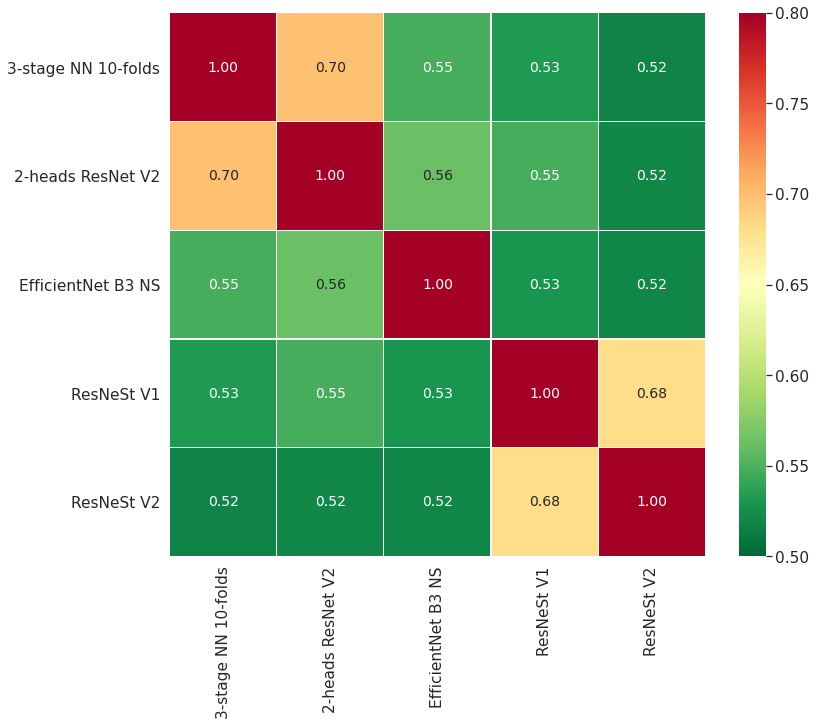

In [45]:
sns.set(font_scale=1.4)
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    corr_df,
    vmin=0.5,
    vmax=0.8,
    # center=0.65,
    fmt='.2f',
    cmap='RdYlGn_r',
    linewidths=0.1,
    linecolor='white',
    # cmap='YlOrRd',
    # cmap='jet',
    annot_kws={"fontsize": 14},
    annot=True)
# center=0.7)
# annot=True)
# cmap='jet')
# cmap='BrBG')
# heatmap.set_title(
#     "Mean Correlation Heatmap of Best CV Models' OOF Predictions (Pearson)",
#     fontdict={'fontsize': 18},
#     pad=12)
sns.set(font_scale=1.0)

### Spearman

In [ ]:
# method = 'spearman'
# mean_oof_corr = np.zeros((all_oof.shape[0], all_oof.shape[0]))
# for i in range(len(model_list)):
#     i_df = pd.DataFrame(all_oof[i])
#     for j in range(len(model_list)):
#         j_df = pd.DataFrame(all_oof[j])
#         print(
#             f'Mean Correlation (column-wise) [Model {i}-{j}]: {i_df.corrwith(j_df, method=method).mean()}'
#         )
#         mean_oof_corr[i, j] = i_df.corrwith(j_df, method=method).mean()

# corr_df = pd.DataFrame(
#     mean_oof_corr,
#     columns=[f'Model-{i}' for i in range(1,
#                                          len(model_list) + 1)])
# corr_df.columns = model_names
# corr_df.index = model_names

In [ ]:
# corr_df

In [ ]:
# print(np.min(corr_df))

In [ ]:
# plt.figure(figsize=(12, 10))
# heatmap = sns.heatmap(mean_oof_corr,
#                       vmin=0.5,
#                       vmax=0.8,
#                       # center=0.6,
#                       fmt='.6g',
#                       cmap='RdYlGn_r',
#                       annot=True)
# # center=0.7)
# # annot=True)
# # cmap='jet')
# # cmap='BrBG')
# heatmap.set_title(
#     'Mean Correlation Heatmap of Best CV OOF Predictions (Spearman)',
#     fontdict={'fontsize': 18},
#     pad=12)

### Kendall

In [ ]:
# method = 'kendall'
# mean_oof_corr = np.zeros((all_oof.shape[0], all_oof.shape[0]))
# for i in range(len(model_list)):
#     i_df = pd.DataFrame(all_oof[i])
#     for j in range(len(model_list)):
#         j_df = pd.DataFrame(all_oof[j])
#         print(
#             f'Mean Correlation (column-wise) [Model {i}-{j}]: {i_df.corrwith(j_df, method=method).mean()}'
#         )
#         mean_oof_corr[i, j] = i_df.corrwith(j_df, method=method).mean()

# corr_df = pd.DataFrame(
#     mean_oof_corr,
#     columns=[f'Model-{i}' for i in range(1,
#                                          len(model_list) + 1)])
# corr_df.columns = model_names
# corr_df.index = model_names

In [ ]:
# corr_df

In [ ]:
# print(np.min(corr_df))

In [ ]:
# plt.figure(figsize=(12, 10))
# heatmap = sns.heatmap(mean_oof_corr,
#                       vmin=0.3,
#                       vmax=0.8,
#                       # center=0.6,
#                       fmt='.6g',
#                       cmap='RdYlGn_r',
#                       annot=True)
# # center=0.7)
# # annot=True)
# # cmap='jet')
# # cmap='BrBG')
# heatmap.set_title(
#     'Mean Correlation Heatmap of Best CV OOF Predictions (Kendall)',
#     fontdict={'fontsize': 18},
#     pad=12)

# Best LB

In [46]:
submission = pd.read_csv(f'{dataset_folder}/sample_submission.csv')

all_submit = np.zeros((7, submission.shape[0], 206))
all_submit.shape

(7, 3982, 206)

In [52]:
# Load submissions
best_LB_models = [
    ("3-stage NN",
     "../../Github/kaggle_moa_team/final/Best LB/Submission/submission_2stageNN_with_ns_oldcv_0.01822.csv"
     ),
    ("2-stage NN+TabNet",
     "../../Github/kaggle_moa_team/final/Best LB/Submission/submission_2stagenn_tabnet.csv"
     ),
    ("Simple NN Old CV",
     "../../Github/kaggle_moa_team/final/Best LB/Submission/submission_script_simpleNN_oldcv_0.01836.csv"
     ),
    ("Simple NN New CV",
     "../../Github/kaggle_moa_team/final/Best LB/Submission/submission_simpleNN_without_ns_newcv.csv"
     ),
    ("2-heads ResNet",
     "../../Github/kaggle_moa_team/final/Best LB/Submission/submission_2heads_oldcv.csv"
     ),
    ("EfficientNet B3 NS",
     "../../Github/kaggle_moa_team/final/Best LB/Submission/submission_effnet_v7_b3.csv"
     ),
    ("ResNeSt V2",
     "../../Github/kaggle_moa_team/final/Best LB/Submission/submission_resnest_v2.csv"
     ),
]

best_LB_model_names = [m[0] for m in best_LB_models]

for i, (_, path) in enumerate(best_LB_models):
    print(path)
    all_submit[i, :, :] = pd.read_csv(path).iloc[:, 1:]

best_LB_model_names

../../Github/kaggle_moa_team/final/Best LB/Submission/submission_2stageNN_with_ns_oldcv_0.01822.csv
../../Github/kaggle_moa_team/final/Best LB/Submission/submission_2stagenn_tabnet.csv
../../Github/kaggle_moa_team/final/Best LB/Submission/submission_script_simpleNN_oldcv_0.01836.csv
../../Github/kaggle_moa_team/final/Best LB/Submission/submission_simpleNN_without_ns_newcv.csv
../../Github/kaggle_moa_team/final/Best LB/Submission/submission_2heads_oldcv.csv
../../Github/kaggle_moa_team/final/Best LB/Submission/submission_effnet_v7_b3.csv
../../Github/kaggle_moa_team/final/Best LB/Submission/submission_resnest_v2.csv


['3-stage NN',
 '2-stage NN+TabNet',
 'Simple NN Old CV',
 'Simple NN New CV',
 '2-heads ResNet',
 'EfficientNet B3 NS',
 'ResNeSt V2']

In [56]:
method = 'pearson'
mean_submit_corr = np.zeros((all_submit.shape[0], all_submit.shape[0]))
for i in range(len(best_LB_models)):
    i_df = pd.DataFrame(all_submit[i])
    for j in range(len(best_LB_models)):
        j_df = pd.DataFrame(all_submit[j])
        print(
            f'Mean Correlation (column-wise) [Model {i}-{j}]: {i_df.corrwith(j_df, method=method).mean()}'
        )
        mean_submit_corr[i, j] = i_df.corrwith(j_df, method=method).mean()

corr_submit_df = pd.DataFrame(
    mean_submit_corr,
    columns=[f'Model-{i}' for i in range(1,
                                         len(best_LB_models) + 1)])
corr_submit_df.columns = best_LB_model_names
corr_submit_df.index = best_LB_model_names

Mean Correlation (column-wise) [Model 0-0]: 1.0
Mean Correlation (column-wise) [Model 0-1]: 0.7732979378861734
Mean Correlation (column-wise) [Model 0-2]: 0.82145167791824
Mean Correlation (column-wise) [Model 0-3]: 0.8312745618668719
Mean Correlation (column-wise) [Model 0-4]: 0.7961179988414498
Mean Correlation (column-wise) [Model 0-5]: 0.7287755400434007
Mean Correlation (column-wise) [Model 0-6]: 0.6848171721513814
Mean Correlation (column-wise) [Model 1-0]: 0.7732979378861734
Mean Correlation (column-wise) [Model 1-1]: 1.0
Mean Correlation (column-wise) [Model 1-2]: 0.8356788863693068
Mean Correlation (column-wise) [Model 1-3]: 0.8529121966864187
Mean Correlation (column-wise) [Model 1-4]: 0.837917241014327
Mean Correlation (column-wise) [Model 1-5]: 0.6828672215467093
Mean Correlation (column-wise) [Model 1-6]: 0.6339335596182246
Mean Correlation (column-wise) [Model 2-0]: 0.82145167791824
Mean Correlation (column-wise) [Model 2-1]: 0.8356788863693068
Mean Correlation (column-wi

In [57]:
corr_submit_df

,3-stage NN,2-stage NN+TabNet,Simple NN Old CV,Simple NN New CV,2-heads ResNet,EfficientNet B3 NS,ResNeSt V2
3-stage NN,1.000000,0.773298,0.821452,0.831275,0.796118,0.728776,0.684817
2-stage NN+TabNet,0.773298,1.000000,0.835679,0.852912,0.837917,0.682867,0.633934
Simple NN Old CV,0.821452,0.835679,1.000000,0.968438,0.821616,0.715458,0.656866
Simple NN New CV,0.831275,0.852912,0.968438,1.000000,0.845993,0.735498,0.680194
2-heads ResNet,0.796118,0.837917,0.821616,0.845993,1.000000,0.777205,0.712734
EfficientNet B3 NS,0.728776,0.682867,0.715458,0.735498,0.777205,1.000000,0.807485
ResNeSt V2,0.684817,0.633934,0.656866,0.680194,0.712734,0.807485,1.000000


In [58]:
print(np.min(corr_submit_df))

3-stage NN            0.684817
2-stage NN+TabNet     0.633934
Simple NN Old CV      0.656866
Simple NN New CV      0.680194
2-heads ResNet        0.712734
EfficientNet B3 NS    0.682867
ResNeSt V2            0.633934
dtype: float64


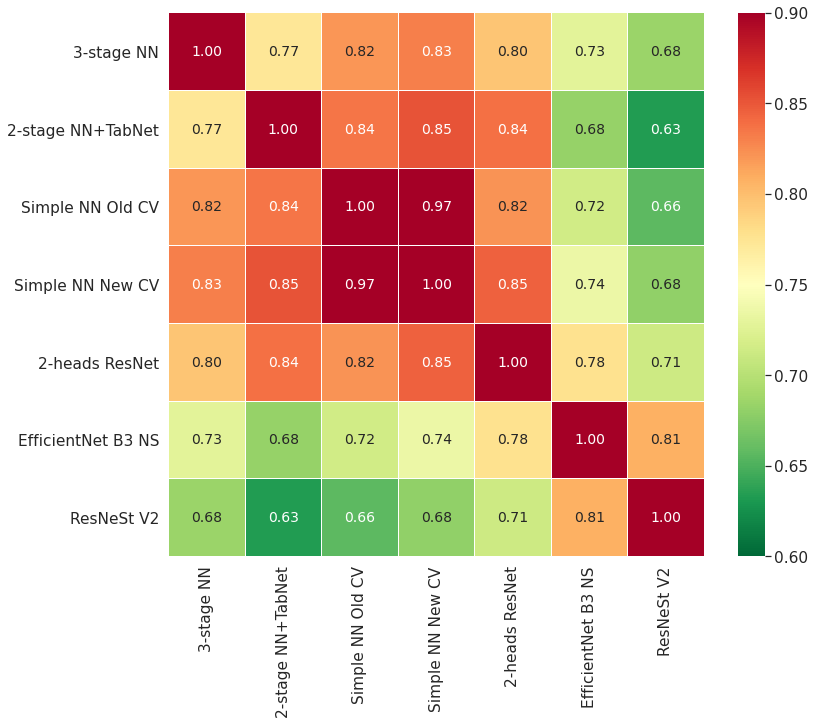

In [61]:
sns.set(font_scale=1.4)
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(
    corr_submit_df,
    vmin=0.6,
    vmax=0.9,
    # center=0.65,
    fmt='.2f',
    cmap='RdYlGn_r',
    linewidths=0.1,
    linecolor='white',
    # cmap='YlOrRd',
    # cmap='jet',
    annot_kws={"fontsize": 14},
    annot=True)
# center=0.7)
# annot=True)
# cmap='jet')
# cmap='BrBG')
# heatmap.set_title(
#     "Mean Correlation Heatmap of Best LB Models' Submission Predictions (Pearson)",
#     fontdict={'fontsize': 18},
#     pad=12)
sns.set(font_scale=1.0)

## EOF

In [ ]:
if kernel_mode:
    !rm ./*.py
    !ls -la